In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [2]:
def fetch_data_from_mysql():
  db_user = 'root'
  db_password = ''
  db_host = 'localhost'
  db_name = 'brezzo'
  
  connection_url = f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}"
  engine = create_engine(connection_url)

  query = "SELECT * FROM aqi_daily"
  df = pd.read_sql(query, con=engine)

  return df

In [3]:
data = fetch_data_from_mysql()
data['date'] = pd.to_datetime(data['date'])

features = data[['co', 'no2', 'o3', 'so2', 'pm2_5', 'pm10']].values
targets = data[['co', 'no2', 'o3', 'so2', 'pm2_5', 'pm10']].values  # Multiple targets

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
targets_scaled = scaler.fit_transform(targets)  # Skala setiap target

In [4]:
time_steps = 1
X = []
y = []

# Loop untuk membuat dataset dengan time steps
for i in range(len(features_scaled) - time_steps):
    X.append(features_scaled[i:i + time_steps])
    y.append(targets_scaled[i + time_steps])  # Ganti 'target' dengan 'targets_scaled'

# Konversi menjadi array NumPy
X, y = np.array(X), np.array(y)

In [5]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential([
    Input(shape=(time_steps, X.shape[2])),
    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(6)
])


model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

epochs = 100
batch_size = 16

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=1,
)

# Menyimpan model setelah pelatihan
model.save('model.h5')  # Menyimpan dalam format H5
# Atau jika Anda lebih suka format SavedModel
# model.save('saved_model/my_model')  # Menyimpan dalam format SavedModel


Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0555 - mae: 0.1716 - val_loss: 0.0164 - val_mae: 0.0924
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122 - mae: 0.0797 - val_loss: 0.0129 - val_mae: 0.0812
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - mae: 0.0648 - val_loss: 0.0111 - val_mae: 0.0774
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - mae: 0.0600 - val_loss: 0.0097 - val_mae: 0.0688
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - mae: 0.0559 - val_loss: 0.0090 - val_mae: 0.0680
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - mae: 0.0501 - val_loss: 0.0082 - val_mae: 0.0621
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061 - mae: 0.0516 - val_loss: 0.0084 - val_mae: 0.0625
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - mae: 0.0484 - val_loss: 0.0075 - val_mae: 0.0594
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.004

In [ ]:
predictions = model.predict(X_test)
predictions_original = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test_original, predictions_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions_original)
r2 = r2_score(y_test_original, predictions_original)


print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R-squared: {r2}')

if r2 >= 0.9:
    print("The LSTM model achieves above 90% accuracy and performs well.")
else:
    print("The LSTM model may need further tuning.")

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0489 - mae: 0.1604 - val_loss: 0.0156 - val_mae: 0.0918
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109 - mae: 0.0735 - val_loss: 0.0121 - val_mae: 0.0785
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - mae: 0.0658 - val_loss: 0.0096 - val_mae: 0.0701
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - mae: 0.0547 - val_loss: 0.0085 - val_mae: 0.0636
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 - mae: 0.0518 - val_loss: 0.0085 - val_mae: 0.0675
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - mae: 0.0494 - val_loss: 0.0073 - val_mae: 0.0590
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050 - mae: 0.0453 - val_loss: 0.0072 - val_mae: 0.0587
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - mae: 0.0478 - val_loss: 0.0070 - val_mae: 0.0592
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.004

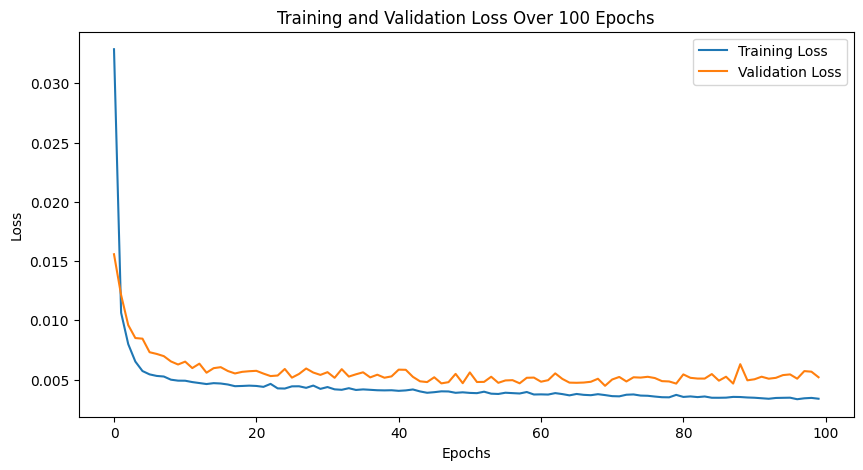

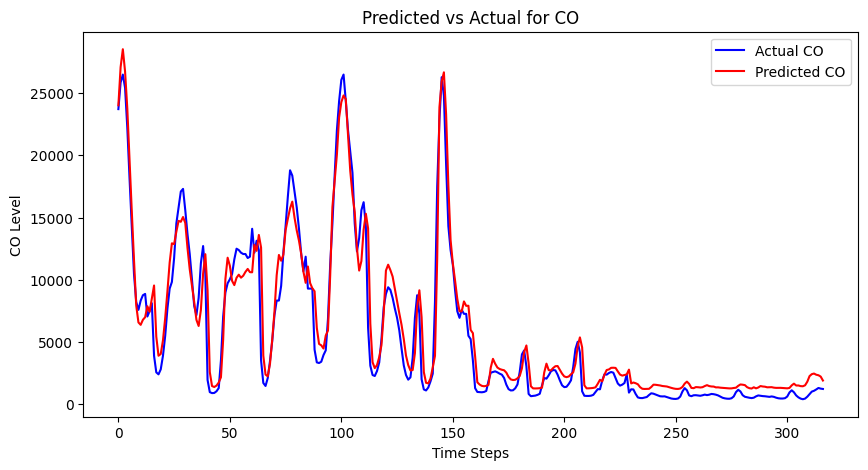

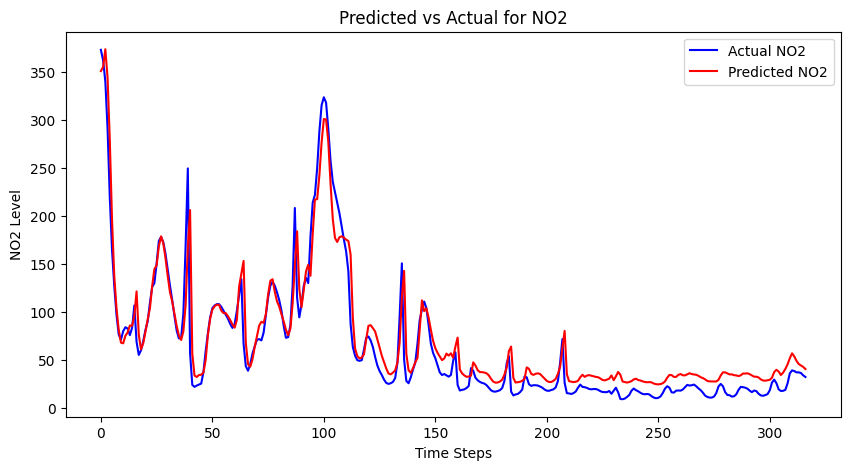

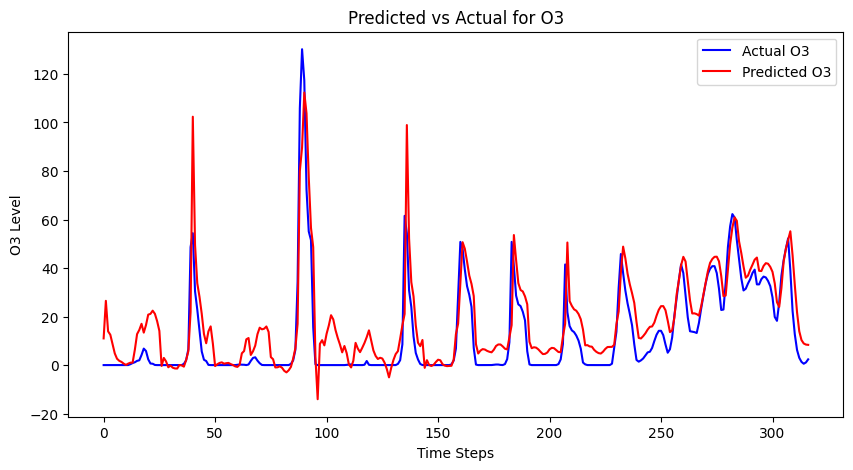

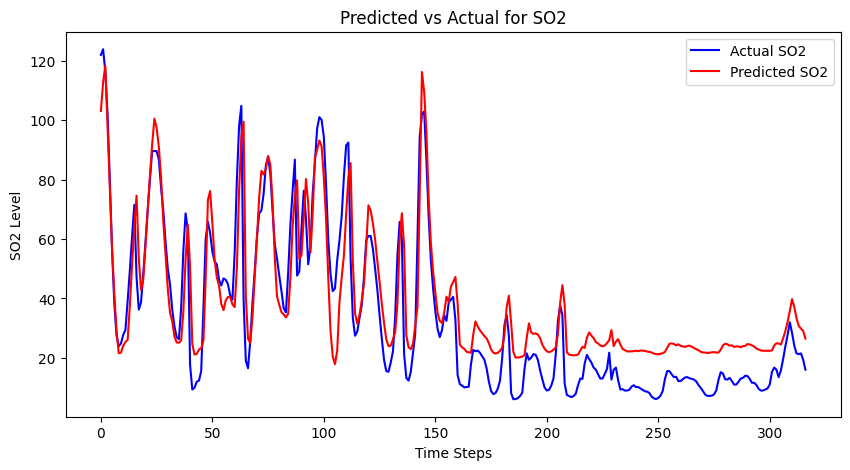

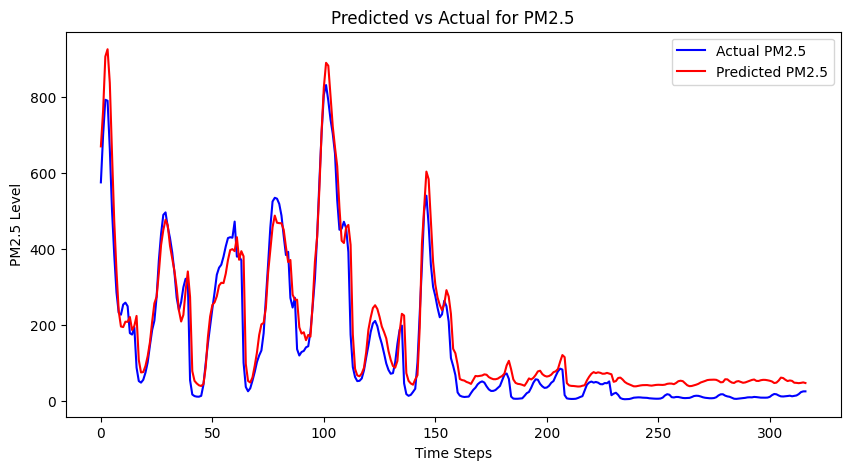

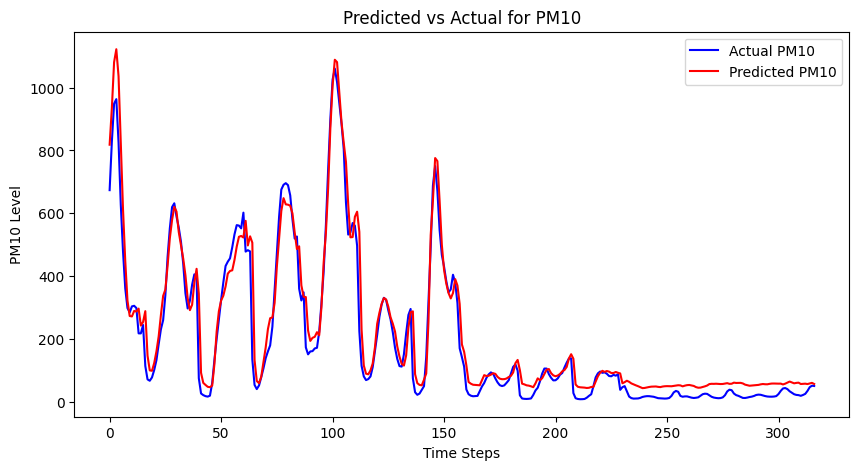

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over 100 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

pollutants = ['CO', 'NO2', 'O3', 'SO2', 'PM2.5', 'PM10']
num_pollutants = len(pollutants)

for i in range(num_pollutants):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_original[:, i], label=f'Actual {pollutants[i]}', color='blue')
    plt.plot(predictions_original[:, i], label=f'Predicted {pollutants[i]}', color='red')
    plt.title(f'Predicted vs Actual for {pollutants[i]}')
    plt.xlabel('Time Steps')
    plt.ylabel(f'{pollutants[i]} Level')
    plt.legend()
    plt.show()

In [12]:
future_steps = 48
last_known_data = X[-1:]  # Data terakhir dengan dimensi (1, time_steps, 6)
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(last_known_data, verbose=0)  # Prediksi untuk semua fitur
    future_predictions.append(pred[0])  # Simpan semua fitur yang diprediksi

    # Update last_known_data dengan prediksi saat ini
    next_input = np.append(last_known_data[0, 1:, :], pred, axis=0)  # Gabungkan prediksi
    last_known_data = next_input.reshape((1, time_steps, X.shape[2]))  # Kembali ke dimensi (1, time_steps, 6)

# Ubah hasil prediksi ke DataFrame
future_dates = pd.date_range(start=data['date'].iloc[-1], periods=future_steps + 1, freq='H')[1:]
future_df = pd.DataFrame(
    future_predictions,
    columns=['co', 'no2', 'o3', 'so2', 'pm2_5', 'pm10']
)
future_df.insert(0, 'datetime', future_dates)

# Tampilkan tabel dengan garis pemisah
print(future_df.to_string(index=False, line_width=100))


           datetime   co  no2   o3  so2  pm2_5  pm10
2024-12-06 00:00:00 0.04 0.06 0.02 0.08   0.04  0.03
2024-12-06 01:00:00 0.05 0.08 0.03 0.10   0.04  0.04
2024-12-06 02:00:00 0.07 0.11 0.04 0.12   0.06  0.05
2024-12-06 03:00:00 0.09 0.14 0.06 0.15   0.07  0.07
2024-12-06 04:00:00 0.12 0.18 0.08 0.18   0.10  0.09
2024-12-06 05:00:00 0.15 0.23 0.11 0.22   0.13  0.13
2024-12-06 06:00:00 0.18 0.27 0.16 0.25   0.17  0.17
2024-12-06 07:00:00 0.17 0.27 0.24 0.25   0.19  0.19
2024-12-06 08:00:00 0.14 0.24 0.32 0.23   0.21  0.19
2024-12-06 09:00:00 0.12 0.20 0.39 0.22   0.23  0.18
2024-12-06 10:00:00 0.10 0.16 0.47 0.21   0.23  0.19
2024-12-06 11:00:00 0.08 0.13 0.54 0.20   0.23  0.19
2024-12-06 12:00:00 0.07 0.11 0.59 0.19   0.23  0.19
2024-12-06 13:00:00 0.07 0.10 0.63 0.19   0.24  0.20
2024-12-06 14:00:00 0.06 0.09 0.67 0.19   0.25  0.21
2024-12-06 15:00:00 0.06 0.09 0.69 0.19   0.26  0.22
2024-12-06 16:00:00 0.06 0.09 0.72 0.19   0.26  0.22
2024-12-06 17:00:00 0.06 0.08 0.74 0.19   0.27

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

def fetch_data_from_mysql():
  db_user = 'root'
  db_password = ''
  db_host = 'localhost'
  db_name = 'brezzo'
  
  connection_url = f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}"
  engine = create_engine(connection_url)

  query = "SELECT * FROM aqi_daily"
  df = pd.read_sql(query, con=engine)

  return df

data = fetch_data_from_mysql()
data['date'] = pd.to_datetime(data['date'])

features = data[['co', 'no2', 'o3', 'so2', 'pm2_5', 'pm10']].values
targets = data[['co', 'no2', 'o3', 'so2', 'pm2_5', 'pm10']].values  # Multiple targets

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
targets_scaled = scaler.fit_transform(targets)  # Skala setiap target

time_steps = 1
X = []
y = []

# Loop untuk membuat dataset dengan time steps
for i in range(len(features_scaled) - time_steps):
    X.append(features_scaled[i:i + time_steps])
    y.append(targets_scaled[i + time_steps])  # Ganti 'target' dengan 'targets_scaled'

# Konversi menjadi array NumPy
X, y = np.array(X), np.array(y)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential([
    Input(shape=(time_steps, X.shape[2])),
    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(6)
])


model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


epochs = 100
batch_size = 16

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=1,
)

predictions = model.predict(X_test)
predictions_original = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test_original, predictions_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions_original)
r2 = r2_score(y_test_original, predictions_original)


print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R-squared: {r2}')

if r2 >= 0.9:
    print("The LSTM model achieves above 90% accuracy and performs well.")
else:
    print("The LSTM model may need further tuning.")
    
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over 100 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

pollutants = ['CO', 'NO2', 'O3', 'SO2', 'PM2.5', 'PM10']
num_pollutants = len(pollutants)

for i in range(num_pollutants):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_original[:, i], label=f'Actual {pollutants[i]}', color='blue')
    plt.plot(predictions_original[:, i], label=f'Predicted {pollutants[i]}', color='red')
    plt.title(f'Predicted vs Actual for {pollutants[i]}')
    plt.xlabel('Time Steps')
    plt.ylabel(f'{pollutants[i]} Level')
    plt.legend()
    plt.show()
    
future_steps = 48
last_known_data = X[-1:]  # Data terakhir dengan dimensi (1, time_steps, 6)
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(last_known_data, verbose=0)  # Prediksi untuk semua fitur
    future_predictions.append(pred[0])  # Simpan semua fitur yang diprediksi

    # Update last_known_data dengan prediksi saat ini
    next_input = np.append(last_known_data[0, 1:, :], pred, axis=0)  # Gabungkan prediksi
    last_known_data = next_input.reshape((1, time_steps, X.shape[2]))  # Kembali ke dimensi (1, time_steps, 6)

# Ubah hasil prediksi ke DataFrame
future_dates = pd.date_range(start=data['date'].iloc[-1], periods=future_steps + 1, freq='H')[1:]
future_df = pd.DataFrame(
    future_predictions,
    columns=['co', 'no2', 'o3', 'so2', 'pm2_5', 'pm10']
)
future_df.insert(0, 'datetime', future_dates)

# Tampilkan tabel dengan garis pemisah
print(future_df.to_string(index=False, line_width=100))
